# DATA CLEANING

In [1]:
import pandas as pd
from geopy.distance import great_circle
import datetime
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('./AIS_2017_01_Zone11.csv')

In [3]:
df['BaseDateTime'] = pd.to_datetime(df['BaseDateTime'])

In [4]:
df.head()

,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,IMO,CallSign,VesselType,Status,Length,Width,Draft,Cargo
0,367067810,2017-01-01 00:00:06,33.74757,-118.21565,0.0,181.7,511.0,NaN,NaN,NaN,NaN,undefined,NaN,NaN,NaN,NaN
1,367001740,2017-01-01 00:00:07,33.34445,-118.32208,0.1,81.0,159.0,NaN,NaN,NaN,NaN,under way using engine,NaN,NaN,NaN,NaN
2,236000990,2017-01-01 00:00:16,32.70992,-117.23312,0.0,203.1,511.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,538004441,2017-01-01 00:00:36,33.74393,-118.20837,0.0,-99.6,310.0,NaN,NaN,NaN,NaN,moored,NaN,NaN,NaN,NaN
4,367452560,2017-01-01 00:01:10,32.76216,-117.23657,0.0,-49.6,511.0,NaN,NaN,NaN,NaN,under way using engine,NaN,NaN,NaN,NaN


In [5]:
# great_circle example
newport_ri = (41.49008, -71.312796)
cleveland_oh = (41.499498, -81.695391)
print(great_circle(newport_ri, cleveland_oh).miles/3)

178.99933023214484


In [6]:
# Subset the data to a single day: Jan 18, 2017
# BaseDateTime_Rounded rounds the timestamps to the nearest 10 minutes
day = df[df['BaseDateTime'].dt.date == datetime.date(2017, 1, 18)]
day['BaseDateTime_Rounded'] = day['BaseDateTime'].dt.round('10min')
day = day.reset_index(drop = True)

/Users/erinhansen/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [7]:
# day.sort_values(by = ['BaseDateTime_Rounded', 'MMSI'])
# Multiple pings for each ship within one half hour -- reduce to "final location"

In [8]:
day_group = pd.DataFrame(day.groupby(['BaseDateTime_Rounded','MMSI'])['BaseDateTime'].max())
day_group = day_group.reset_index()
len(day_group) #71057

71057

In [9]:
day_cleaned = day.merge(day_group, on = ['MMSI', 'BaseDateTime'], how = 'inner')
len(day_cleaned) #71058
# Need to find and delete the duplicate

71058

In [10]:
x = pd.DataFrame(day_cleaned.groupby(['BaseDateTime_Rounded_x','MMSI'])['BaseDateTime'].count())
x[x['BaseDateTime'] > 1]

,,BaseDateTime
BaseDateTime_Rounded_x,MMSI,
2017-01-19,338208628,2


In [11]:
day_cleaned[day_cleaned['MMSI'] == 338208628][day_cleaned[day_cleaned['MMSI'] == 338208628]['BaseDateTime_Rounded_x'] == datetime.date(2017, 1, 19)]

/Users/erinhansen/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and 'the values will not compare equal to the
'datetime.date'. To retain the current behavior, convert the
'datetime.date' to a datetime with 'pd.Timestamp'.
  """Entry point for launching an IPython kernel.


,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,IMO,CallSign,VesselType,Status,Length,Width,Draft,Cargo,BaseDateTime_Rounded_x,BaseDateTime_Rounded_y
61437,338208628,2017-01-18 23:59:59,33.61033,-117.89535,0.0,-178.2,511.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-01-19,2017-01-19
61438,338208628,2017-01-18 23:59:59,33.61033,-117.89535,0.0,-178.2,511.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-01-19,2017-01-19


In [12]:
day_cleaned = day_cleaned.drop(index = 61438)
len(day_cleaned) #71057

71057

In [13]:
day_cleaned = day_cleaned.reset_index(drop = True)
day_cleaned = day_cleaned.drop(['BaseDateTime_Rounded_y'], axis = 1)
day_cleaned = day_cleaned.rename(columns = {'BaseDateTime_Rounded_x': 'BaseDateTime_Rounded'})
day_cleaned.head()

,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,IMO,CallSign,VesselType,Status,Length,Width,Draft,Cargo,BaseDateTime_Rounded
0,338003172,2017-01-18 00:02:16,32.68178,-117.17348,0.0,-51.7,511.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-01-18
1,367700910,2017-01-18 00:00:30,33.60945,-117.88925,0.0,-75.5,511.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-01-18
2,201216315,2017-01-18 00:00:14,31.83917,-116.62549,10.4,11.1,511.0,PILOTOS II,IMO201216315,NaN,50.0,under way using engine,13.0,6.0,0.0,50.0,2017-01-18
3,338190245,2017-01-18 00:00:04,34.19769,-119.21749,0.1,112.1,511.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-01-18
4,338212878,2017-01-18 00:01:15,32.76342,-117.23689,0.0,19.5,511.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-01-18


# CALCULATE DISTANCES

In [ ]:
# For every 10 min, find distance between all ships. Keep only distance < 8000 yards. 
# Will place in buckets: 500, 1000, 8000 yards
# Don't calculate distance of boat with itself.
# Of the ones that are within range, are they heading toward each other?? Or away? If away, remove.

In [17]:
# Use static ship1 and time for testing purposes 
# ship = 367507960
# time = datetime.date(2017, 1, 19)
# print(ship, time)

In [14]:
basedatetime = []
ship1 = []
ship2 = []
distance = []

for time in day_cleaned['BaseDateTime_Rounded'].unique():
    df_time = pd.DataFrame(day_cleaned[day_cleaned['BaseDateTime_Rounded'] == time]).reset_index(drop = True)
    for ship in df_time['MMSI']:
        ship1_loc = (df_time[df_time['MMSI'] == ship].iloc[0]['LAT'], df_time[df_time['MMSI'] == ship].iloc[0]['LON'])
        for i in range(len(df_time)):
            if df_time.loc[i, 'MMSI'] != ship: #and df_time.loc[i, 'MMSI'] not in ship1:
                basedatetime.append(time)
                ship1.append(ship)
                ship2.append(df_time.loc[i, 'MMSI'])
                ship2_loc = (df_time.loc[i, 'LAT'], df_time.loc[i, 'LON'])
                distance.append(great_circle(ship1_loc, ship2_loc).feet/3) # convert to yards

In [16]:
len(distance) == len(ship1) == len(ship2) == len(basedatetime)

True

In [17]:
df_results = pd.DataFrame()
df_results['BaseDateTime'] = basedatetime
df_results['Ship1'] = ship1
df_results['Ship2'] = ship2
df_results['Distance'] = distance

In [18]:
# should return no results
df_results[df_results['Ship1'] == df_results['Ship2']]

,BaseDateTime,Ship1,Ship2,Distance


In [19]:
df_results['dupe_check'] = df_results['Ship1'] + df_results['Ship2'] # unique identifier for pairs of ships
len(df_results) #34850788

34850788

In [20]:
len(df_results)/2

17425394.0

In [21]:
# Drop duplicates
df_results['Distance'] = round(df_results['Distance'],5)
df_results = df_results.drop_duplicates(['dupe_check', 'BaseDateTime', 'Distance'])
len(df_results) #17425636 -- should equal (or at least very close to) original len/2

17425636

In [22]:
df_results['Distance'].describe()

count    1.742564e+07
mean     1.195895e+05
std      9.156637e+04
min      0.000000e+00
25%      3.595089e+04
50%      1.233674e+05
75%      1.665717e+05
max      1.067950e+06
Name: Distance, dtype: float64

# FIND ENCOUNTERS

In [378]:
# Add SOG so we can remove "instances" where neither boat is moving
# Add direction (either COG or Heading) to check if they are on track to intersect

In [23]:
df_8000 = df_results[df_results['Distance'] < 8000].reset_index(drop = True)
len(df_8000)

2011665

In [24]:
# Merge in Ship1 data
df_8000 = df_8000.merge(day_cleaned[['BaseDateTime', 'SOG', 'COG', 'Heading', 'Status', 'MMSI', 'BaseDateTime_Rounded', 'VesselType', 'Length']]
                        , left_on = ['Ship1', 'BaseDateTime'], right_on = ['MMSI', 'BaseDateTime_Rounded'])
df_8000 = df_8000.drop(['BaseDateTime_x', 'MMSI'], axis = 1)
df_8000 = df_8000.rename(columns = {'BaseDateTime_y':'BaseDateTime', 'SOG':'SOG1', 'COG':'COG1'
                                    , 'Heading':'Heading1', 'Status':'Status1', 'VesselType': 'VesselType1', 'Length': 'Length1'})
# df_8000.head()

In [25]:
# Merge in Ship2 data
df_8000 = df_8000.merge(day_cleaned[['BaseDateTime', 'SOG', 'COG', 'Heading', 'Status', 'MMSI', 'BaseDateTime_Rounded', 'VesselType', 'Length']]
                        , left_on = ['Ship2', 'BaseDateTime_Rounded'], right_on = ['MMSI', 'BaseDateTime_Rounded'])
df_8000 = df_8000.drop(['BaseDateTime_y', 'MMSI'], axis = 1)
df_8000 = df_8000.rename(columns = {'BaseDateTime_x':'BaseDateTime', 'SOG':'SOG2', 'COG':'COG2'
                                    , 'Heading':'Heading2', 'Status':'Status2', 'VesselType': 'VesselType2', 'Length': 'Length2'})
# df_8000.head()

In [26]:
df_1000 = df_8000[df_8000['Distance'] < 1000].reset_index(drop = True)
df_500 = df_1000[df_1000['Distance'] < 500].reset_index(drop = True)
print('8000 yards: '+ str(len(df_8000)), '\n1000 yards: ' + str(len(df_1000)), '\n500 yards: ' + str(len(df_500)))

8000 yards: 2011665 
1000 yards: 427108 
500 yards: 199168


In [203]:
# At least 1 ship should be moving
# SOG = Speed Over Ground
# df_500_instances = df_500[df_500['SOG1'] + df_500['SOG2'] > 0.10]
df_8000_instances = df_8000[df_8000['SOG1'] + df_8000['SOG2'] > 0.10]
len(df_8000_instances)
# len(df_500_instances)

11452

In [201]:
# NaN status does not appear to be indicative of any special behavior... originally thought it would mean sitting idle
# df_500_instances[df_500_instances['Status1'].isna()]['SOG2'].describe()

df_8000_instances.head()

,Ship1,Ship2,Distance,dupe_check,BaseDateTime,SOG1,COG1,Heading1,Status1,BaseDateTime_Rounded,...,Length1,SOG2,COG2,Heading2,Status2,VesselType2,Length2,instance_count,stationary,Instance Type
0,338003172,538005238,5954.55091,876008410,2017-01-18 00:02:16,0.0,-51.7,511.0,NaN,2017-01-18 00:00:00,...,NaN,0.3,-157.9,304.0,at anchor,NaN,NaN,16,0.0,Stationary Ship
1,338003172,538005238,5959.37055,876008410,2017-01-18 00:14:16,0.1,-139.4,511.0,NaN,2017-01-18 00:10:00,...,NaN,0.3,99.5,335.0,at anchor,NaN,NaN,16,0.0,Stationary Ship
2,338003172,538005238,5952.96520,876008410,2017-01-18 00:29:16,0.0,-139.4,511.0,NaN,2017-01-18 00:30:00,...,NaN,0.6,-136.5,307.0,at anchor,NaN,NaN,16,0.0,Stationary Ship
3,538005238,338003172,5953.05629,876008410,2017-01-18 00:44:30,0.4,26.2,336.0,at anchor,2017-01-18 00:40:00,...,NaN,0.0,-162.1,511.0,NaN,NaN,NaN,16,0.0,Stationary Ship
4,338003172,538005238,5955.76539,876008410,2017-01-18 01:14:18,0.0,-65.4,511.0,NaN,2017-01-18 01:10:00,...,NaN,0.4,132.0,323.0,at anchor,NaN,NaN,16,0.0,Stationary Ship


# CATEGORIZE ENCOUNTERS

In [ ]:
# Single encounter: entered proximity and left
# Multiple encounters, 1 is anchored
# Multiple encounters, both moving
    # Moving in same direction?
    # Plot time (minutes in proximity starting at 0) against distance
    # Need first ping, and diff between timestamp and first ping/10 minutes (i.e. 0, 1, 2, 4, etc.)
    # Start with 8000 yards?

In [31]:
# Find Single Encounters
# counts = pd.DataFrame(df_500_instances.groupby(['dupe_check'])['Ship1'].count())
# counts = counts.reset_index()
# counts.columns = ['dupe_check', 'instance_count']
# df_500_instances = df_500_instances.merge(counts, on = ['dupe_check'])
# df_500_instances.head()

counts = pd.DataFrame(df_8000_instances.groupby(['dupe_check'])['Ship1'].count())
counts = counts.reset_index()
counts.columns = ['dupe_check', 'instance_count']
df_8000_instances = df_8000_instances.merge(counts, on = ['dupe_check'])

In [32]:
# Find encounters where 1 ship is not moving
# min_sog = pd.DataFrame(df_500_instances.groupby(['dupe_check'])['SOG1', 'SOG2'].min())
# min_sog = min_sog.reset_index()
# min_sog['stationary'] = min_sog['SOG1']*min_sog['SOG2']
# for i in range(len(min_sog)):
#     if min_sog.loc[i, 'SOG1'] == 0.1:
#         min_sog.loc[i, 'stationary'] = 0.0
#     if min_sog.loc[i, 'SOG2'] == 0.1:
#         min_sog.loc[i, 'stationary'] = 0.0
# df_500_instances = df_500_instances.merge(min_sog[['dupe_check','stationary']], on = ['dupe_check'])

min_sog = pd.DataFrame(df_8000_instances.groupby(['dupe_check'])['SOG1', 'SOG2'].min())
min_sog = min_sog.reset_index()
min_sog['stationary'] = min_sog['SOG1']*min_sog['SOG2']
for i in range(len(min_sog)):
    if min_sog.loc[i, 'SOG1'] == 0.1:
        min_sog.loc[i, 'stationary'] = 0.0
    if min_sog.loc[i, 'SOG2'] == 0.1:
        min_sog.loc[i, 'stationary'] = 0.0
df_8000_instances = df_8000_instances.merge(min_sog[['dupe_check','stationary']], on = ['dupe_check'])

In [33]:
# types = []
# for i in range(len(df_500_instances)):
#     if df_500_instances.loc[i, 'instance_count'] == 1:
#         types.append('Single Encounter')
#     elif df_500_instances.loc[i, 'stationary'] == 0.0:
#         types.append('Stationary Ship')
#     else:
#         types.append('Both Moving')

types = []
for i in range(len(df_8000_instances)):
    if df_8000_instances.loc[i, 'instance_count'] == 1:
        types.append('Single Encounter')
    elif df_8000_instances.loc[i, 'stationary'] == 0.0:
        types.append('Stationary Ship')
    else:
        types.append('Both Moving')

## breakdown of type

In [34]:
# df_500_instances['Instance Type'] = types
# df_500_instances.groupby(['Instance Type'])['Ship1'].count()

# ~99% of encounters are ships moving around or near a stationary ship
# ~63% of the rest are "passerby" situations; briefly enter proximity and then leave

df_8000_instances['Instance Type'] = types
df_8000_instances.groupby(['Instance Type'])['Ship1'].count()

Instance Type
Both Moving           1503
Single Encounter      2565
Stationary Ship     309736
Name: Ship1, dtype: int64

In [35]:
# moving_500 = df_500_instances[df_500_instances['Instance Type'] == 'Both Moving']
moving_8000 = df_8000_instances[df_8000_instances['Instance Type'] == 'Both Moving']

In [36]:
# first_encounter = pd.DataFrame(moving_500.groupby(['dupe_check'])['BaseDateTime_Rounded'].min())
# first_encounter = first_encounter.reset_index()
# first_encounter.columns = ['dupe_check', 'first_encounter']
# moving_8000 = moving_500.merge(first_encounter, on = 'dupe_check', how = 'left')

first_encounter = pd.DataFrame(moving_8000.groupby(['dupe_check'])['BaseDateTime_Rounded'].min())
first_encounter = first_encounter.reset_index()
first_encounter.columns = ['dupe_check', 'first_encounter']
moving_8000 = moving_8000.merge(first_encounter, on = 'dupe_check', how = 'left')

In [37]:
# moving_500['Time Index'] = (moving_500['BaseDateTime_Rounded'] - moving_500['first_encounter']).astype('timedelta64[m]')/10

moving_8000['Time Index'] = (moving_8000['BaseDateTime_Rounded'] - moving_8000['first_encounter']).astype('timedelta64[m]')/10

In [309]:
moving_8000.to_excel('./moving_8000.xlsx')

In [276]:
# df_500_instances[df_500_instances['dupe_check'] == 720189830].sort_values(by = ['BaseDateTime'])

In [273]:
# df_results[df_results['dupe_check'] == 720189830].sort_values(by = ['BaseDateTime'])[60:]

In [274]:
# day_cleaned[day_cleaned['MMSI'] == 367569830].sort_values(by = ['BaseDateTime'])[60:]

In [275]:
# great_circle((33.76342, -118.24803), (33.75323, -118.26513)).miles

# 'Moving' encounters by VesselType

In [272]:
## Look by VesselType
# Most common interaction is freight ships and tank ships (IDs 1004 and 1024)
# They interact more with each other than with themselves. Likely that ships within categories travel along same path
# and therefore interact less.

# They get out of each other's way as quickly as possible (most interactions less than 10 min and > 5K yards)
# Do smaller ships behave differently?
day_cleaned.count()

MMSI                    71057
BaseDateTime            71057
LAT                     71057
LON                     71057
SOG                     71057
COG                     71057
Heading                 71057
VesselName              18152
IMO                     12810
CallSign                17286
VesselType              18152
Status                  33440
Length                  17422
Width                   17365
Draft                   16728
Cargo                   18189
BaseDateTime_Rounded    71057
dtype: int64

In [310]:
day_cleaned.groupby(['VesselType'])['Length', 'Width', 'Draft', 'Cargo'].mean()

,Length,Width,Draft,Cargo
VesselType,,,,
0.0,149.731343,22.925373,6.500000,0.000000
23.0,30.000000,8.000000,4.000000,23.931034
30.0,35.000000,7.000000,2.200000,30.000000
31.0,16.100592,7.100592,2.366864,31.000000
32.0,22.000000,8.000000,3.000000,32.000000
35.0,82.500000,7.500000,-4.200000,35.000000
37.0,0.000000,0.000000,3.000000,37.000000
40.0,42.000000,12.000000,3.700000,40.000000
50.0,8.937500,4.125000,0.000000,50.000000


In [320]:
# Majority of ships are small ships, however majority of instances occur between 2 large ships.
print(len(day_cleaned[day_cleaned['Length'] > 100])/len(day_cleaned[~day_cleaned['Length'].isna()]))

0.4165997015268052


In [313]:
day_cleaned.groupby(['VesselType'])['MMSI'].count()

VesselType
0.0        230
23.0       145
30.0       145
31.0       169
32.0       145
35.0       435
37.0        36
40.0       101
50.0        16
52.0       315
53.0       155
54.0         6
60.0       145
70.0        71
89.0       144
90.0         5
1001.0      14
1003.0      57
1004.0    3080
1005.0     578
1010.0    1247
1011.0     433
1012.0    1896
1018.0     412
1019.0    1757
1020.0     497
1024.0    2924
1025.0    2994
Name: MMSI, dtype: int64

# Predicting Size of Ship2

In [15]:
# If we know size of Ship1 and we see an interaction happening, can we predict size (length >/< 100) of Ship2?
# Can we predict size if we *don't* know anything about Ship1?
# Is 100 feet a good cut-off for length? Introduce X-Large?
# Is it possible NaNs are biasing data? (are there really more of ship type X than we see with this data?)

# Longer-term project could be predicting VesselType

In [222]:
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc

In [44]:
len(df_8000_instances[~df_8000_instances['Length2'].isna() & ~df_8000_instances['Length1'].isna()])

55241

In [208]:
df_ml = df_8000_instances[~df_8000_instances['Length2'].isna() & ~df_8000_instances['Length1'].isna()]
len(df_ml)
df_ml = df_ml.reset_index(drop = True)

In [209]:
size1 = []
size2 = []
for i in range(len(df_ml)):
    if df_ml.loc[i, 'Length1'] > 100:
        size1.append(1)
    else:
        size1.append(0)
    if df_ml.loc[i, 'Length2'] > 100:
        size2.append(1)
    else:
        size2.append(0)

In [210]:
df_ml['Size1'] = size1
df_ml['Size2'] = size2

In [211]:
first_encounter = pd.DataFrame(df_ml.groupby(['dupe_check'])['BaseDateTime_Rounded'].min())
first_encounter = first_encounter.reset_index()
first_encounter.columns = ['dupe_check', 'first_encounter']
df_ml = df_ml.merge(first_encounter, on = 'dupe_check', how = 'left')

df_ml['Time Index'] = (df_ml['BaseDateTime_Rounded'] - df_ml['first_encounter']).astype('timedelta64[m]')/10

In [212]:
df_ml = df_ml.drop(['Ship1', 'Ship2', 'dupe_check', 'BaseDateTime', 'BaseDateTime_Rounded',
                    'VesselType1', 'VesselType2', 'Length1', 'Length2', 'instance_count', 
                    'stationary', #'Instance Type',
                    'Status1', 'Status2','first_encounter'], axis = 1)
df_ml.head()

,Distance,SOG1,COG1,Heading1,SOG2,COG2,Heading2,Instance Type,Size1,Size2,Time Index
0,7593.30558,0.0,-185.4,511.0,4.3,-121.5,290.0,Stationary Ship,0,0,0.0
1,6748.90702,0.0,-173.6,511.0,4.0,-81.7,330.0,Stationary Ship,0,0,1.0
2,7407.28167,5.5,-57.5,351.0,0.1,-153.9,511.0,Stationary Ship,0,0,2.0
3,2075.27757,0.0,-153.8,511.0,5.1,69.5,511.0,Single Encounter,0,0,0.0
4,3616.73339,0.0,64.0,223.0,5.1,69.5,511.0,Single Encounter,0,0,0.0


In [213]:
types = []
for i in range(len(df_ml)):
    if df_ml.loc[i, 'Instance Type'] == 'Stationary Ship':
        types.append(0)
    elif df_ml.loc[i, 'Instance Type'] == 'Single Encounter':
        types.append(1)
    else:
        types.append(2)
        
df_ml['Type'] = types
df_ml = df_ml.drop(['Instance Type'], axis = 1)

In [214]:
df_ml = df_ml[df_ml['Type'] == 2]
df_ml = df_ml.drop(['Type'], axis = 1)

In [215]:
X = df_ml.drop(['Size2'], axis = 1)
y = df_ml['Size2']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [216]:
print(len(X_train), len(X_test), len(y_train), len(y_test))

253 64 253 64


In [217]:
gm = GaussianMixture(n_components = 2)
gm.means_init = np.array([X_train[y_train == i].mean(axis=0)
                            for i in range(2)])
gm.fit(X_train, y_train)
pred = gm.predict(X_test)

In [218]:
cm = confusion_matrix(y_test, pred)
print (cm)

[[ 7 11]
 [ 5 41]]


In [219]:
print ('Test accuracy = ' + str(accuracy_score(y_test, pred)))

Test accuracy = 0.75


In [187]:
# Single Encounters: almost impossible to tell (~52% accuracy)
# Stationary: little better, not much (~57%)
# Both Moving: 75% accuracy but most are large anyway. Need more data.

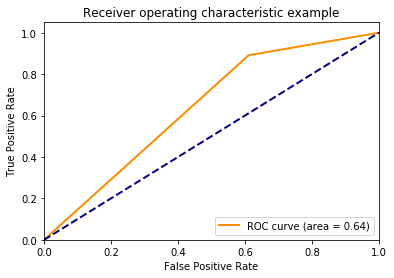

In [226]:
fpr, tpr, _ = roc_curve(y_test.ravel(), pred.ravel())
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()